# Tiếp cận bài toán
### Đề bài đưa ra yêu cầu xây dựng một mô hình dự đoán biến động giá trong tương lai với công thức đưa ra là:
<center>  
 Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.
</center>

### Từ công thức trên rút ra được chỉ cần xây dựng mô hình dự đoán giá tương lai sau đó trừ đi giá cổ phiếu hiện tại (bởi vì giá cổ phiếu hiện tại đã có sẵn).
### Với cách tiếp cận bài toán như vậy sẽ khiến việc xây dựng mô hình dễ dàng hơn và đưa ra các dự đoán chính xác hơn.


In [19]:
# Kết nối drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.layers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow import keras

In [21]:
df_fpt = pd.read_csv('/content/drive/MyDrive/Phạm Bằng 12A2/FPT.csv')

In [22]:
df_fpt.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [23]:
df_fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [24]:
df_fpt['Date/Time'] = pd.to_datetime(df_fpt['Date/Time'])

In [25]:
df1 = pd.DataFrame(df_fpt, columns = ['Date/Time', 'Close'])
df1.head()

,Date/Time,Close
0,2018-12-25 09:15:00,30.89
1,2018-12-25 09:16:00,30.81
2,2018-12-25 09:17:00,30.74
3,2018-12-25 09:18:00,30.74
4,2018-12-25 09:19:00,30.74


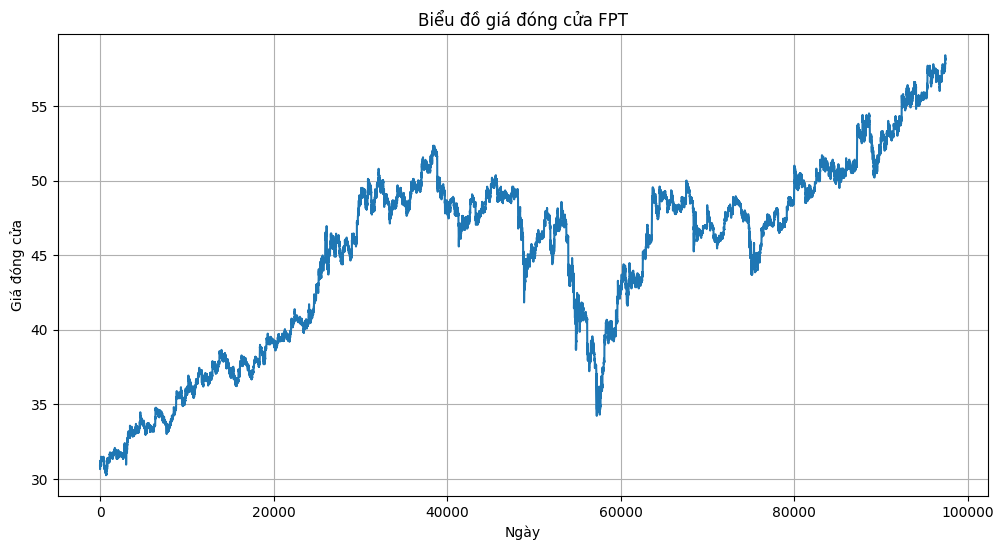

In [26]:
# Vẽ đồ thị đường cho df1
plt.figure(figsize=(12, 6))
plt.plot(df1.index, df1['Close'])
plt.title('Biểu đồ giá đóng cửa FPT')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.grid(True)
plt.show()


In [27]:
series_fpt = np.array(df1['Close'])
time_fpt = np.array(df1['Date/Time'])

In [28]:
# Chuẩn hóa dữ liệu
sc = StandardScaler()
series_fpt = sc.fit_transform(series_fpt.reshape(-1, 1))
series_fpt = series_fpt.flatten()

In [29]:
# Chia dữ liệu thành train, val, test
split_time_train = int(len(series_fpt) * 0.8)
split_time_test = int(len(series_fpt) * 0.9)
train_data = series_fpt[:split_time_train]
train_time = time_fpt[:split_time_train]
val_data = series_fpt[split_time_train:split_time_test]
val_time = time_fpt[split_time_train:split_time_test]
test_data = series_fpt[split_time_test:]
test_time = time_fpt[split_time_test:]

In [30]:
# Các tham số cần thiết
window_size = 100
batch_size = 64
shuffle_buffer = 1000

In [31]:
# Hàm tạo tập dữ liệu phù hợp
def window_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 5, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 5))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-5], window[-5:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [32]:
# Hàm dự đoán
## N là thời gian người nhập muốn dự đoán giá cổ phiếu trong tương lai (tối thiểu 1 - tối đa 5 phút)
def model_forcast(model, series, window_size, N):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(64).prefetch(1)
  forecast = model.predict(ds)
  forecast = sc.inverse_transform(forecast)
  forecast = forecast[:,N-1]
  return forecast

In [33]:
def draw_plot(predict, data, time, window_size, N):
  # Chuyển đổi dữ liệu dự đoán về dạng mảng NumPy
  test_data_inverse = sc.inverse_transform(data.reshape(-1,1))
  predict = predict.flatten()  # Chuyển về 1D nếu cần
  # Vẽ biểu đồ
  plt.figure(figsize=(12, 6))
  # Vẽ biểu đồ giá dự đoán và giá thực tế
  plt.subplot(1, 2, 1)
  plt.plot(time[window_size + N - 1:], test_data_inverse[window_size + N - 1:], label="Giá trị thực tế", color='blue')
  plt.plot(time[window_size + N - 1:], predict[ : - N], label="Giá trị dự đoán", color='red')

  # Thêm tiêu đề và nhãn
  plt.title("biểu đồ giá dự đoán và giá thực tế")
  plt.xlabel("Thời gian")
  plt.xticks(rotation=45)
  plt.ylabel("Giá đóng cửa")
  plt.legend()
  plt.grid(True)

  # vẽ biểu đồ chênh lệch giá dự đoán và chênh lệch giá thực tế
  predict = predict.reshape(-1,1)
  price_change_real = test_data_inverse[window_size + N - 1:] - test_data_inverse[window_size - 1:-N]
  price_change_predict = predict[ : - N] - test_data_inverse[window_size - 1:-N]
  price_change_real = price_change_real.flatten()
  price_change_predict = price_change_predict.flatten()

  plt.subplot(1, 2, 2)
  plt.plot(time[window_size + N - 1:], price_change_real, label="chênh lệch giá thực tế", color='blue')
  plt.plot(time[window_size + N - 1:], price_change_predict, label="chênh lệch giá dự đoán", color='red')

  # Thêm tiêu đề và nhãn
  plt.title("biểu đồ chênh lệch giá dự đoán và chênh lệch giá thực tế")
  plt.xlabel("Thời gian")
  plt.xticks(rotation=45)
  plt.ylabel("chênh lệch giá")
  plt.legend()
  plt.grid(True)

  # Hiển thị biểu đồ
  plt.show()


In [34]:
tf.random.set_seed(0)
np.random.seed(0)
# Tạo tập dữ liệu phù hợp
train_set = window_dataset(train_data, window_size = window_size, batch_size = batch_size, shuffle_buffer = shuffle_buffer)
val_set = window_dataset(val_data, window_size = window_size, batch_size = batch_size, shuffle_buffer = shuffle_buffer)

In [35]:
model = Sequential([
    Input(shape=(None, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(5),
])
model.compile(loss="mse", optimizer="adam", metrics=['mae'])
history = model.fit(train_set,epochs = 5, validation_data=val_set)

Epoch 1/5
   1216/Unknown 635s 516ms/step - loss: 0.3657 - mae: 0.3498

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 664s 541ms/step - loss: 0.3655 - mae: 0.3496 - val_loss: 0.0024 - val_mae: 0.0372
Epoch 2/5
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 665s 527ms/step - loss: 0.0702 - mae: 0.1814 - val_loss: 6.0526e-04 - val_mae: 0.0186
Epoch 3/5
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 628s 516ms/step - loss: 0.0532 - mae: 0.1596 - val_loss: 4.5600e-04 - val_mae: 0.0151
Epoch 4/5
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 740s 564ms/step - loss: 0.0442 - mae: 0.1475 - val_loss: 0.0032 - val_mae: 0.0528
Epoch 5/5
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 699s 528ms/step - loss: 0.0385 - mae: 0.1387 - val_loss: 2.8498e-04 - val_mae: 0.0110


In [36]:
# Lưu model vào Google Drive
model.save('/content/drive/MyDrive/Phạm Bằng 12A2/lstm_model_fpt.h5')


In [37]:
# Tải mô hình đã lưu
model = keras.models.load_model('/content/drive/MyDrive/Phạm Bằng 12A2/lstm_model_fpt.h5',
                                custom_objects={'mse': tf.keras.losses.MeanSquaredError()})


# Dự đoán với dữ liệu cổ phiếu FPT

In [38]:
# Dự đoán chênh lệch giá ở N = 2
lstm_fpt_predict = model_forcast(model, test_data, window_size, 2)

151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 188ms/step


In [39]:
lstm_fpt_predict.shape

(9642,)

In [40]:
for i in range(10):
  print(lstm_fpt_predict[i])

52.51597
52.520702
52.552578
52.591118
52.6238
52.66786
52.664375
52.636444
52.647217
52.654465


In [41]:
test_data_inverse = sc.inverse_transform(test_data.reshape(-1,1))


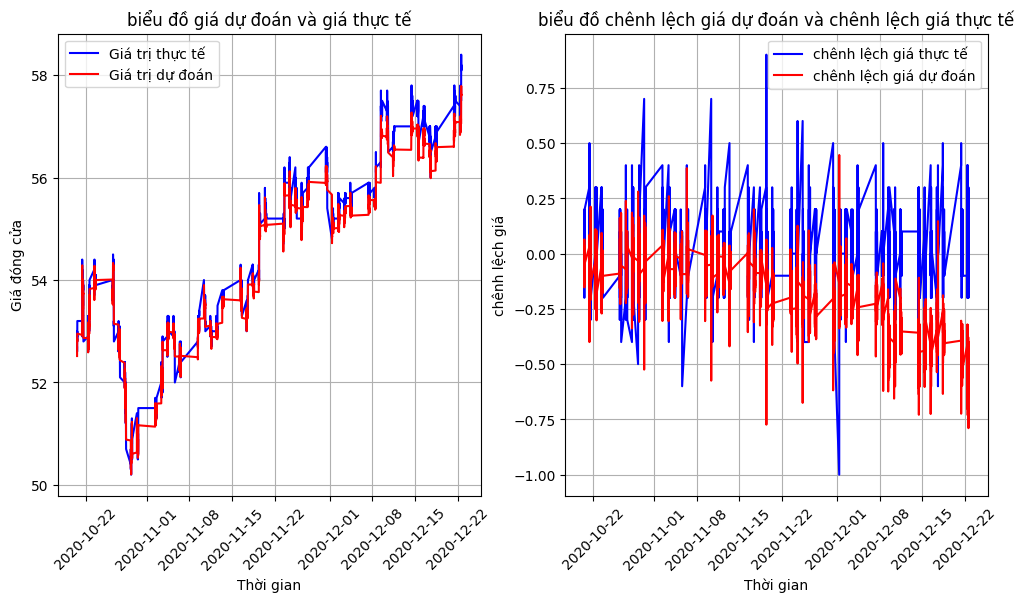

In [42]:
draw_plot(lstm_fpt_predict, test_data, test_time, window_size, 2)

# Dự đoán với dữ liệu cổ phiếu MSN

In [43]:
# Dự đoán với cổ phiếu MSN
df_msn = pd.read_csv('/content/drive/MyDrive/Phạm Bằng 12A2/MSN.csv')
df_msn['Date/Time'] = pd.to_datetime(df_msn['Date/Time'])
df2 = pd.DataFrame(df_msn, columns = ['Date/Time', 'Close'])
df2.head()

,Date/Time,Close
0,2017-12-25 09:15:00,73.1
1,2017-12-25 09:16:00,73.0
2,2017-12-25 09:18:00,73.5
3,2017-12-25 09:20:00,73.1
4,2017-12-25 09:21:00,73.0


In [44]:
series_msn = np.array(df2['Close'])
time_msn = np.array(df2['Date/Time'])

In [45]:
series_msn = sc.fit_transform(series_msn.reshape(-1, 1))
series_msn = series_msn.flatten()

In [46]:
# Dự đoán giá ở N = 2
lstm_msn_predict = model_forcast(model, series_msn, window_size, 2)

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 381s 180ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [47]:
test_data_msn_inverse = sc.inverse_transform(series_msn.reshape(-1,1))

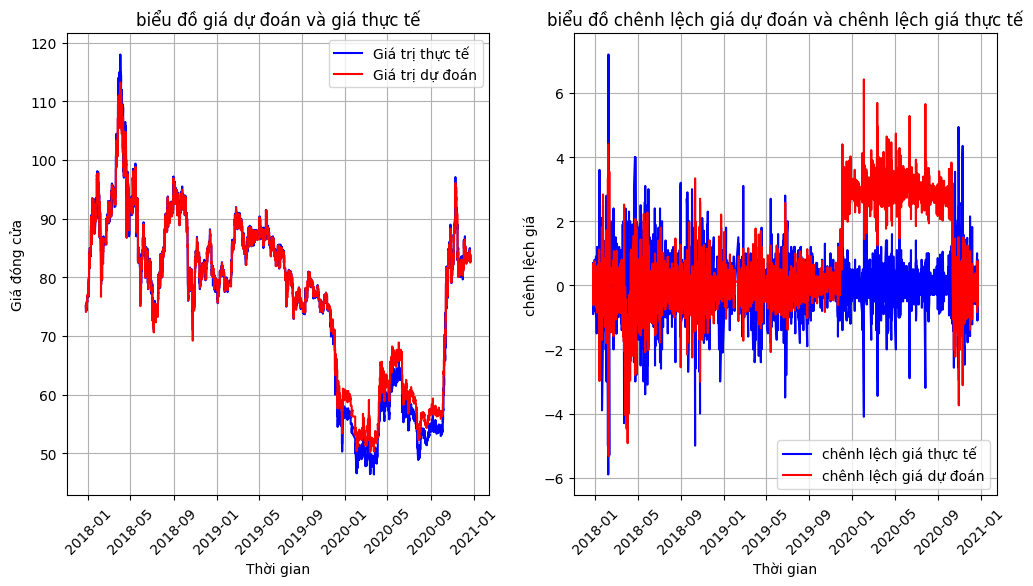

In [48]:
draw_plot(lstm_msn_predict, series_msn, time_msn, window_size, 2)

# Dự đoán với dữ liệu cổ phiếu PNJ

In [49]:
# Dự đoán với cổ phiếu PNJ
df_pnj = pd.read_csv('/content/drive/MyDrive/Phạm Bằng 12A2/PNJ.csv')
df_pnj['Date/Time'] = pd.to_datetime(df_pnj['Date/Time'])
df3 = pd.DataFrame(df_pnj, columns = ['Date/Time', 'Close'])
df3.head()

,Date/Time,Close
0,2018-02-28 09:15:00,78.99
1,2018-02-28 09:16:00,78.94
2,2018-02-28 09:19:00,78.14
3,2018-02-28 09:20:00,78.14
4,2018-02-28 09:21:00,78.14


In [50]:
series_pnj = np.array(df3['Close'])
time_pnj = np.array(df3['Date/Time'])

In [51]:
series_pnj = sc.fit_transform(series_pnj.reshape(-1, 1))
series_pnj = series_pnj.flatten()

In [52]:
# Dự đoán giá ở N = 2
lstm_pnj_predict = model_forcast(model, series_pnj, window_size, 2)

1957/1957 ━━━━━━━━━━━━━━━━━━━━ 354s 181ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [53]:
test_data_pnj_inverse = sc.inverse_transform(series_pnj.reshape(-1,1))

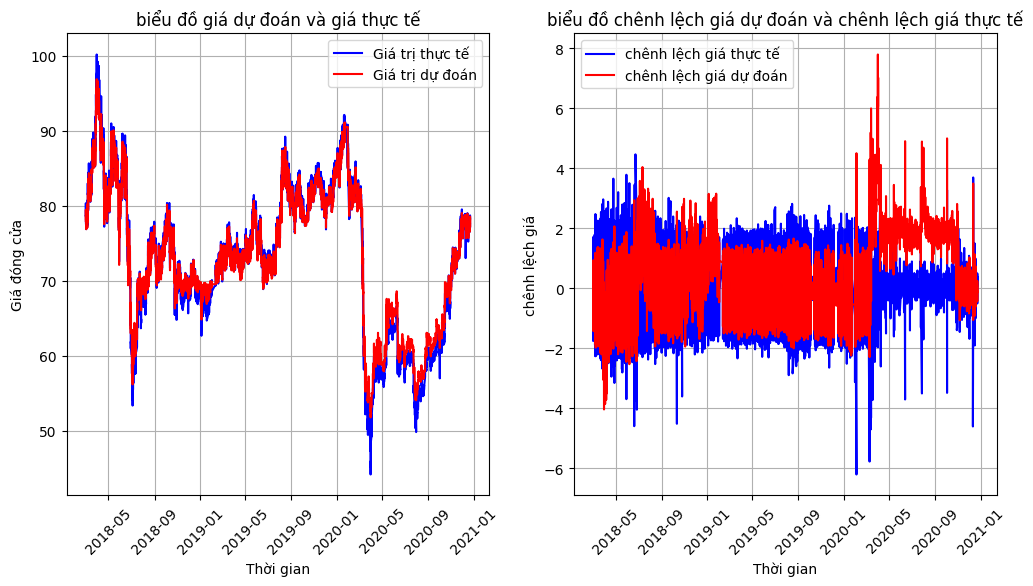

In [54]:
draw_plot(lstm_pnj_predict, series_pnj, time_pnj, window_size, 2)

# Dự đoán với dữ liệu cổ phiếu VIC

In [55]:
# Dự đoán với cổ phiếu PNJ
df_vic = pd.read_csv('/content/drive/MyDrive/Phạm Bằng 12A2/VIC.csv')
df_vic['Date/Time'] = pd.to_datetime(df_vic['Date/Time'])
df4 = pd.DataFrame(df_vic, columns = ['Date/Time', 'Close'])
df4.head()

,Date/Time,Close
0,2018-10-17 09:39:00,98.5
1,2018-10-17 09:40:00,98.5
2,2018-10-17 09:41:00,98.6
3,2018-10-17 09:42:00,98.6
4,2018-10-17 09:43:00,98.7


In [56]:
series_vic = np.array(df4['Close'])
time_vic = np.array(df4['Date/Time'])

In [57]:
series_vic = sc.fit_transform(series_vic.reshape(-1, 1))
series_vic = series_vic.flatten()

In [58]:
# Dự đoán giá ở N = 2
lstm_vic_predict = model_forcast(model, series_vic, window_size, 2)

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 357s 226ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [59]:
test_data_vic_inverse = sc.inverse_transform(series_vic.reshape(-1,1))

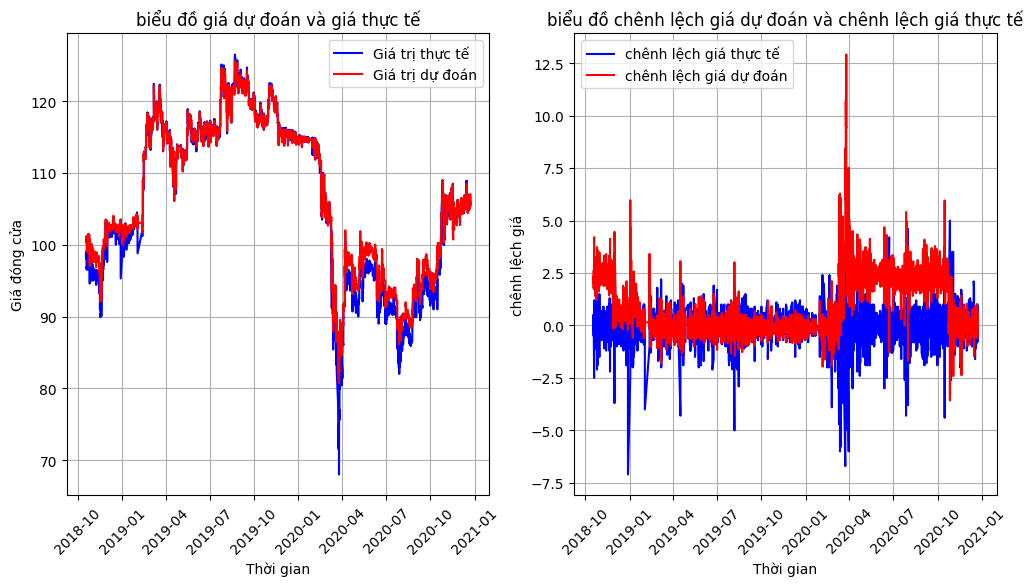

In [60]:
draw_plot(lstm_vic_predict, series_vic, time_vic, window_size, 2)

# Nhận xét:
## Điểm tích cực của mô hình
* Mô hình bám sát khá tốt xu hướng giá thực tế,đặc biệt trong các giai đoạn có biến động nhỏ.

## Điểm chưa tốt của mô hình
* Mô hình chưa xử lý tốt trong giai đoạn biến động lớn.